In [21]:
from urllib.request import urlopen
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.stats import ttest_ind
from wordcloud import WordCloud, STOPWORDS

import os
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *

OFF_API_PATH = "https://world.openfoodfacts.org/{}.json"
OFF_API_QUERY_PATH = "https://world.openfoodfacts.org/cgi/search.pl?{}&page_size=1000&action=process&json=1"
figsize=(12, 10)

dfConso = pd.read_csv("../data/Table_conso.csv", sep=";", encoding="ansi")
dfIndiv = pd.read_csv("../data/Table_indiv.csv", sep=";", encoding="ansi")
dfCapiCA = pd.read_csv("../data/Table_capi_ca.csv", sep=";", encoding="ansi")
dfCarnetCA = pd.read_csv("../data/Table_carnet_ca_1.csv", sep=";", encoding="ansi")
dfIndivCA = pd.read_csv("../data/Table_indiv_ca.csv", sep=";", encoding="ansi")
dfIndnut = pd.read_csv("../data/Table_indnut.csv", sep=";", encoding="ansi")
dfMenage = pd.read_csv("../data/Table_menage_1.csv", sep=";", encoding="ansi")
dfRepas = pd.read_csv("../data/Table_repas.csv", sep=";", encoding="ansi")
dfNomenclature = pd.read_csv("../data/Nomenclature_3.csv", sep=";", encoding="ansi")
dfCorrespondance = pd.concat([pd.read_csv("../data/correspondance_reponses.csv", sep=";", encoding="ansi"), pd.read_csv("../data/correspondance_custom.csv", sep=";", encoding="ansi")])
dfDataNames = pd.concat([pd.read_csv("../data/Data_names_all.csv", sep=";", encoding="ansi"), pd.read_csv("../data/Data_names_custom.csv", sep=";", encoding="ansi")])

# dfCorrespondance = pd.read_csv("../data/correspondance_reponses.csv", sep=";", encoding="ansi")
# dfDataNames = pd.read_csv("../data/Data_names_all.csv", sep=";", encoding="ansi")



C:\Users\josep\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (150,151,152,153,154,155) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Table_capi_ca.csv
Table_carnet_ca_1.csv
Table_conso.csv
Table_indiv.csv
Table_indiv_ca.csv
Table_indnut.csv
Table_menage_1.csv
Table_repas.csv
correspondance_reponses.csv

In [10]:
dfCorrespondance.head(10)

,Libellé du codage,code,Signification
0,a5gglo,1,rural
1,a5gglo,2,2 000 à 20 000 hab.
2,a5gglo,3,20 000 à 100 000 hab.
3,a5gglo,4,> 100 000 hab
4,a5gglo,5,agglo paris
5,a9gglo,1,rural
6,a9gglo,2,2 000 à 5 000 hab.
7,a9gglo,3,5 000 à 10 000 hab.
8,a9gglo,4,10 000 à 20 000 hab.
9,a9gglo,5,20 000 à 50 000 hab.


In [11]:
dfDataNames.head(5)

,Nom de la variable,Type,Libellé du codage,Libellé de la variable
0,achapub,Numérique,pub,Demande à acheter des produits pour lesquels i...
1,achpub1,Numérique,achpub,A acheté Aliment 1 - Publicité
2,achpub2,Numérique,achpub,A acheté Aliment 2 - Publicité
3,achpub3,Numérique,achpub,A acheté Aliment 3 - Publicité
4,achpub4,Numérique,achpub,A acheté Aliment 4 - Publicité


In [12]:
dfDataCorrespondance = dfDataNames.merge(dfCorrespondance,left_on="Libellé du codage", right_on="Libellé du codage", how="inner")

In [13]:
def findCorrespondance(val, column):
    """
    Returns the correspondance of the numerical val for the corresponding column.
    """
    try:
        meaning = dfDataCorrespondance[(dfDataCorrespondance["Nom de la variable"] == column) & (dfDataCorrespondance["code"] == val)]["Signification"].values[0]
    except IndexError:
        meaning = val
    return meaning

def mapCorrespondances(vals, column):
    """
    Returns the correspondance of the numerical val for the corresponding column.
    """
    return [findCorrespondance(val, column) for val in vals]

def findDescription(column):
    """
    Returns the description of the column signification.
    """
    return dfDataNames[(dfDataNames["Nom de la variable"] == column)]["Libellé de la variable"].values[0]

def mapDescription(columns):
    """
    Returns the description of the columns signification.
    """
    return [findDescription(column) for column in columns]

In [15]:
dfIndivO18 = dfIndiv[dfIndiv["tage"]>=4]
print(mapCorrespondances([i for i in range(4, 9)], "tage"))

['18-24 ans', '25-34 ans', '35-49 ans', '50-64 ans', '65 ans et +']


## Explore the data
### INCA2

In [16]:
# Group CSP
# new_category (code) = {old_cat_A (code), old_cat_B (code), ...}
# agriculteur (1) = {agriculteur (1)}
# artisan, commerçant, chef d'entreprise (2) = {artisan (2), commerçant (3), chef d'entreprise (4), profession libérale (5)}
# cadre, prof. intellect. sup. (3) = {cadre, prof. intellect. sup. (6)}
# profession intermédiaire (4) = {contremaître, agent de maitrise (7), technicien (8), autre prof. intermédiaire (9)}
# employé (5) = {employé (10)}
# ouvrier (6) = {ouvrier qualifié (11), ouvrier non qualifié (12)}
# retraité (7) = {retraité(e), pré-retraité(e) (16), retiré des affaires (ancien agri., art.) (17)}
# inactif (8) = {chômeur inscrit ou non à l'anpe (14), etudiant-élève-formation-stage non rémunéré (15), femme ou homme au foyer (18), autre inactif (pension de réversion, invalidité) (19)}
# refus (0) = {refus (13), [refus] (20)}

cspiToCspi2_dict = {1: [1], 2: [2, 3, 4, 5], 3: [6], 4: [7, 8, 9], 5: [10], 6: [11, 12], 7: [16, 17], 8: [14, 15, 18, 19], 0: [13, 20]}

def cspiToCspi2(code):
    for k in cspiToCspi2_dict.keys():
        if code in cspiToCspi2_dict[k]:
            return(k)

serieCspi2 = dfIndivO18["cspi"].apply(lambda x : cspiToCspi2(x))
dfIndivO18 = dfIndivO18.assign(cspi2=serieCspi2)

# Remove the only one "refus"
dfIndivO18 = dfIndivO18[dfIndivO18['cspi2'] != 0]

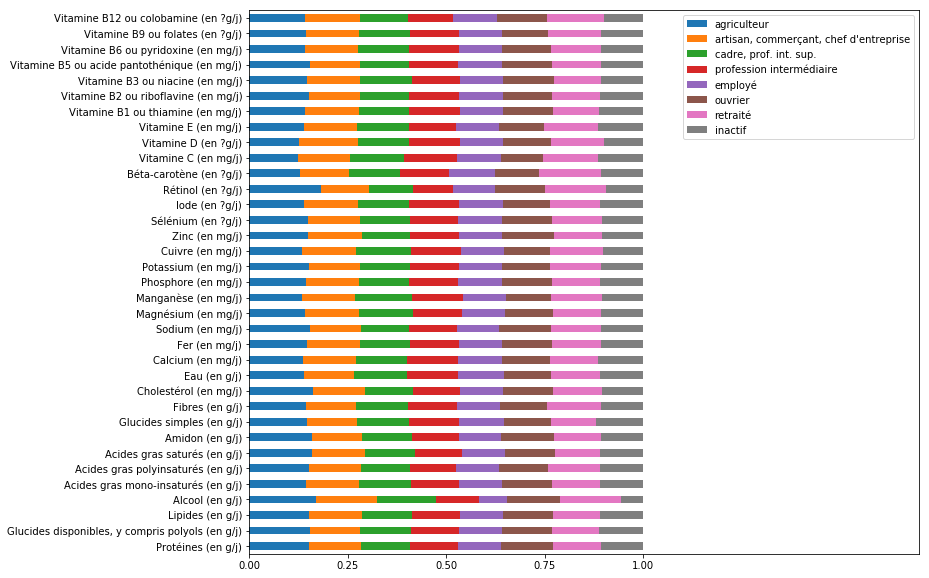

                                        cspi2
agriculteur                                37
artisan, commerçant, chef d'entreprise     99
cadre, prof. int. sup.                    211
profession intermédiaire                  430
employé                                   587
ouvrier                                   316
retraité                                  550
inactif                                   393


In [22]:
# listCSP = mapAllCorrespondances("cspi")
# print(listCSP)
# dfIndivO18["cspi"].apply(lambda x : findCorrespondance(x, "cspi"))
def exploreNut_compareMeans(varOfInterest):
    """Probably very similar to plotMeanValues()."""
    dfNutIndivO18 = dfIndnut.merge(dfIndivO18, left_on="nomen", right_on="nomen", how="inner")
    numFeatures = ["nutj{}".format(i) for i in range(4, 29)]\
                + ["nutj{}".format(i) for i in range(30, 40)]
#                 + ["poidsm", "taille", "tele", "intense_j", "modere_j", "marche_j"]
    featuresNames = mapDescription(numFeatures)
    nutMeans = dfNutIndivO18.groupby(varOfInterest).mean()[numFeatures]
    nutMeans.columns = featuresNames
    nutMeans /= nutMeans.sum(axis=0)
    nutMeans = nutMeans.swapaxes(0, 1)
    nutMeans.columns = mapCorrespondances(nutMeans.columns, varOfInterest)
    
    ax = nutMeans.plot.barh(stacked=True, figsize=figsize, xticks = [0, 0.25, 0.5, 0.75, 1])
    ax.set_xlim([0, 1.7])
    ax.legend(loc=1)
    plt.show()
    
def countDistribution(varOfInterest):
    countVOI = dfIndivO18[[varOfInterest]].groupby(varOfInterest)\
                                        .agg({varOfInterest:"count"})
    countVOI.index = mapCorrespondances(countVOI.index, varOfInterest)
    print(countVOI)

    
exploreNut_compareMeans("cspi2")
countDistribution('cspi2')

In [6]:
marqCounts = dfConso\
    .groupby("libmarq")\
    .agg({"codal": "count"}, as_index=False)\
    .rename(columns={"codal": "count"})\
    .sort_values("count", ascending=False)
marqCounts

,count
libmarq,
x,305523
carrefour,8077
cristaline,6537
leader price,6528
auchan,6344
u,4622
champion,3530
coca cola,3453
dia,3297


In [7]:
print("Brands with more than one item: {} / {}".format(len(marqCounts[marqCounts["count"] > 1]), len(marqCounts)))

Brands with more than one item: 3885 / 7234


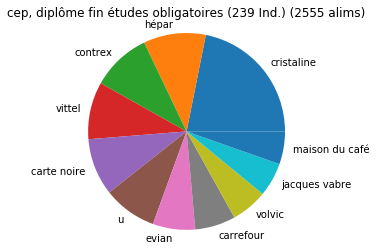

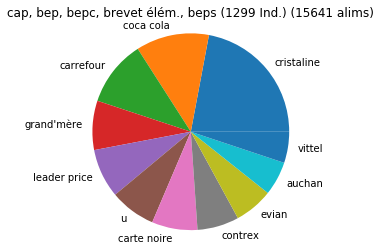

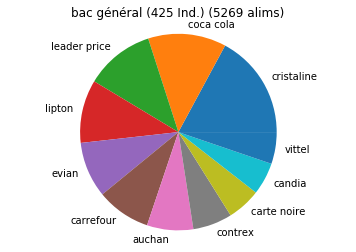

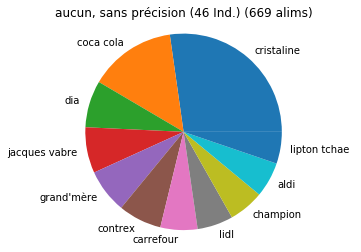

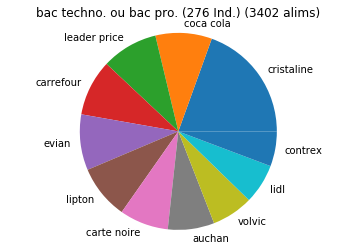

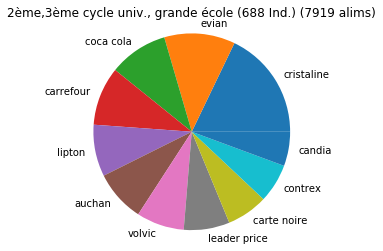

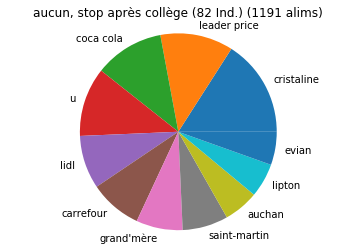

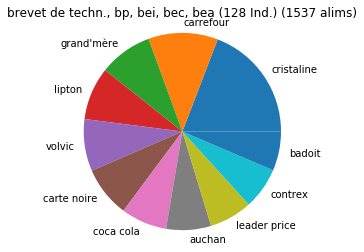

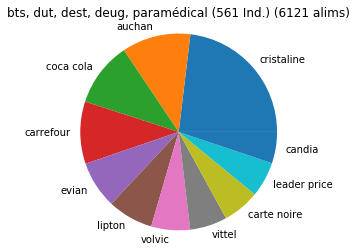

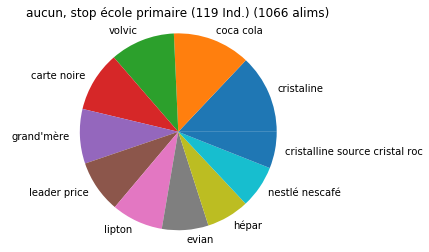

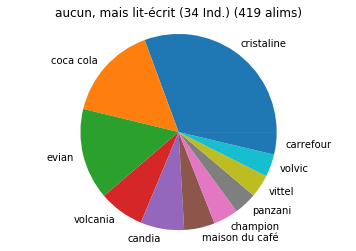

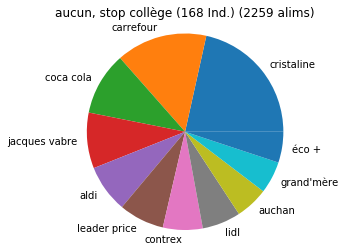

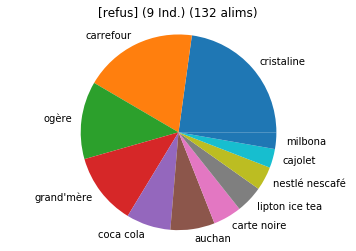

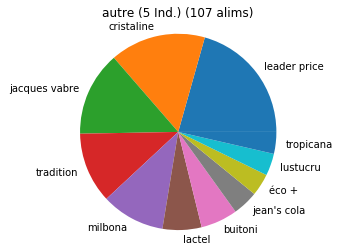

In [8]:
df = dfIndiv.merge(dfConso, left_on="nomen", right_on="nomen", how="inner")
dfBrands = df.groupby(["dip", "libmarq"], as_index=False).agg({"codal": "count", "qte_nette": "sum"}).rename(columns={"codal": "count"})
#dfBrands = dfBrands[dfBrands["count"] > 3]

diplomes = df["dip"].unique()
feature = "qte_nette"

for diplome in diplomes:
    fig, ax = plt.subplots()
    dfBrandsDiplomes = dfBrands[dfBrands.dip == diplome].sort_values(feature, ascending=False)
    ax.pie(x = dfBrandsDiplomes[feature][1:12], labels = dfBrandsDiplomes.libmarq[1:12])
    ax.axis("equal")
    ax.set_title("{} ({} Ind.) ({} alims)".format(findCorrespondance(diplome, "dip"), dfIndiv[dfIndiv["dip"] == diplome].shape[0], dfBrandsDiplomes["count"][1:12].sum()))
plt.show()

# Openfoodfacts

In [9]:
result = json.load(urlopen(OFF_API_PATH.format("brands")))

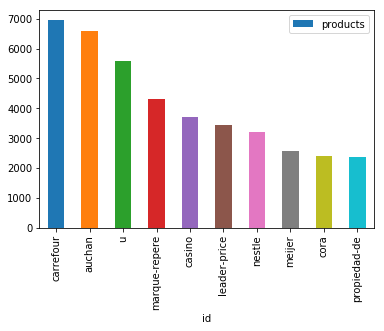

In [10]:
df = pd.DataFrame.from_records(result["tags"])
df.head(10).plot.bar(x="id", y="products")
plt.show()

In [365]:
def getOFFDataFrame(adress, path = OFF_API_PATH):
    """
    Queries OFF database with local adress contained in adress. Formatting url is contained in path.
    """
    result = json.load(urlopen(path.format(adress)))
#     print("{} entries gathered".format(result["count"]))
    if "products" in result:
        return pd.DataFrame(result["products"])
    return pd.DataFrame(result["tags"])

def getOFFDataFrameDict(qdict, n = 1000):
    """
    Gathers OFF dataframe with query contained in dictionary qdict.
    """
    q = "&".join(["{}={}".format(key, value) for key, value in qdict.items()])
    return getOFFDataFrame(q, OFF_API_QUERY_PATH)

def getOFFDataFrameDictAux(qdict, n = 1000, log=False):
    """
    Gathers OFF dataframe with query contained in dictionary qdict.
    """
    q = "&".join(["{}={}".format(key, value) for key, value in qdict.items()])
    i = 1
    dfs = []
    nbCurr = -1
    nbSamples = 0
    while (nbCurr != 0) & (nbSamples < n):
        dfs.append(getOFFDataFrame(q + "&page=" + str(i), OFF_API_QUERY_PATH))
        nbCurr = dfs[-1].shape[0]
        nbSamples += nbCurr
        i += 1
        if log: 
            print("{} samples gathered.".format(nbSamples))
    return pd.concat(dfs).head(n)

def getOFFDataFrameCat(tags=[], nutriments=[], n = 1000, log=False, **kwargs):
    """
    Queries the OFF data base with query informations contained in tags and nutriments. 
    <ul>
        <li>Tags should be a list of lists of shape: 
        [tag, value, &lt;conatins&gt;] where tag is the category of tag (ex. "brands") and value, the value to 
        be searched (ex. "Carrefour")</li>
        <li>Nutriments should be a list of lists of shape: [nutriment, comparison, value] where nutriment is the name of the nutriment to be 
        searched (ex. "magnesium"), comparison the nature of the comparison (ex. "lte") and 
        value the value to be compared with (ex. 50)</li>
    </ul>
    """
    qdict = {}
    qdict.update(parseTags(tags))
    qdict.update(parseNutriments(nutriments))
    qdict.update(kwargs)
    
    return getOFFDataFrameDictAux(qdict, n, log)

def parseTags(tags):
    """
    Converts tags into an appropriate dictionary like shape
    """
    qdict = {}
    for i, tagsEl in enumerate(tags):
        if len(tagsEl) == 2:
            contains = True
        else:
            contains = tagsEl[2]
        qdict["tagtype_{}".format(i)] = tagsEl[0]
        qdict["tag_contains_{}".format(i)] = ["does_not_contain","contains"][int(contains)]
        qdict["tag_{}".format(i)] = tagsEl[1]
    return qdict

def parseNutriments(nutriments):
    """
    Converts nutriments into an appropriate dictionary like shape
    """
    qdict = {}
    for i, nutrimentsEl in enumerate(nutriments):
        qdict["nutriment_{}".format(i)] = nutrimentsEl[0]
        qdict["nutriment_compare_{}".format(i)] = nutrimentsEl[1]
        qdict["nutriment_value_{}".format(i)] = nutrimentsEl[2]
        nutriment_i += 1
    return qdict

In [326]:
help(getOFFDataFameCat)

Help on function getOFFDataFrameCat in module __main__:

getOFFDataFrameCat(tags=[], nutriments=[], n=1000, log=False, **kwargs)
    Queries the OFF data base with query informations contained in tags and nutriments. 
    :param tags: the list of tag parameters for the query. Should contain a list of tuples containing    ``[tagname, tagvalue,<contains>]``. ``tagname`` is the name of the tag, ``tagvalue`` the value    contained (or not) in the tag and ``contains`` defines whether the value should be contained    or not (default True).



In [12]:
labelsDf = getOFFDataFrame("labels")
labelsDf = labelsDf.sort_values("products", ascending=False)

10157 entries gathered


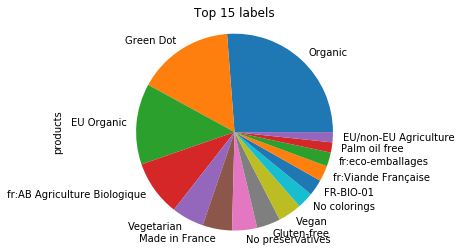

In [76]:
df = labelsDf.head(15)
df.plot.pie(labels=df["name"], y="products", legend=False)
plt.axis("equal")
plt.title("Top 15 labels")
plt.show()

8046 entries gathered


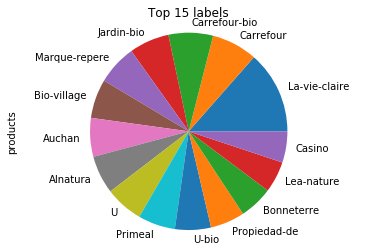

In [77]:
organicBrandsDf = getOFFDataFrame("label/organic/brands")
organicBrandsDf = organicBrandsDf.sort_values("products", ascending=False)
df = organicBrandsDf.head(15)
df.plot.pie(labels=df["name"], y="products", legend=False)
plt.axis("equal")
plt.title("Top 15 labels")
plt.show()

In [107]:
organicBrandsDf = getOFFDataFrameDict({"tagtype_0": "labels", "tag_contains_0": "contains","tag_0": "organic"})


37891 entries gathered


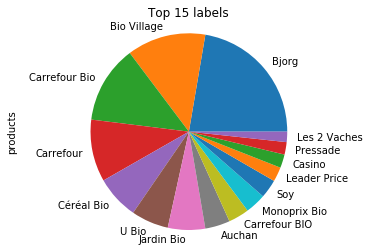

In [129]:
organicBrand = organicBrandsDf.copy()
organicBrand["brand"] = organicBrand["brands"].str.split(pat =",", expand=True)[0]
organicBrand = organicBrand.groupby("brand").agg({"brand": "max", "_id": "count"}).rename(columns = {"_id":"products"})
organicBrand = organicBrand.sort_values("products", ascending=False)
df = organicBrand.head(15)
df.plot.pie(labels=df["brand"], y="products", legend=False)
plt.axis("equal")
plt.title("Top 15 labels")
plt.show()

37891 entries gathered


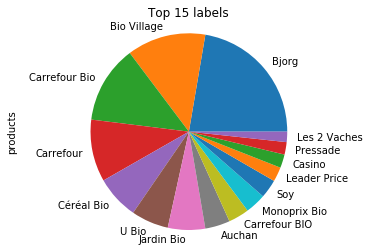

In [132]:
organicBrandsDf = getOFFDataFrameCat(tags = [["labels", "organic"]])
organicBrand = organicBrandsDf.copy()
organicBrand["brand"] = organicBrand["brands"].str.split(pat =",", expand=True)[0]
organicBrand = organicBrand.groupby("brand").agg({"brand": "max", "_id": "count"}).rename(columns = {"_id":"products"})
organicBrand = organicBrand.sort_values("products", ascending=False)
df = organicBrand.head(15)
df.plot.pie(labels=df["brand"], y="products", legend=False)
plt.axis("equal")
plt.title("Top 15 labels")
plt.show()

In [ ]:
organicDf = getOFFDataFrameCat(tags = [["labels", "organic"]], n= 20000, log=True)
nonOrganicDf = getOFFDataFrameCat(tags = [["labels", "organic", False]], n=30000, log=True)

37922 entries gathered
1000 samples gathered.
37922 entries gathered
2000 samples gathered.
37922 entries gathered
3000 samples gathered.
37922 entries gathered
4000 samples gathered.
37922 entries gathered
5000 samples gathered.
37922 entries gathered
6000 samples gathered.
37922 entries gathered
7000 samples gathered.
37922 entries gathered
8000 samples gathered.
37922 entries gathered
9000 samples gathered.
37922 entries gathered
10000 samples gathered.
37922 entries gathered
11000 samples gathered.
37922 entries gathered
12000 samples gathered.
37922 entries gathered
13000 samples gathered.
37922 entries gathered
14000 samples gathered.
37922 entries gathered
15000 samples gathered.
37922 entries gathered
16000 samples gathered.
37922 entries gathered
17000 samples gathered.
37922 entries gathered
18000 samples gathered.
37922 entries gathered
19000 samples gathered.
37922 entries gathered
20000 samples gathered.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



662632 entries gathered
1000 samples gathered.
662632 entries gathered
2000 samples gathered.
662632 entries gathered
3000 samples gathered.
662632 entries gathered
4000 samples gathered.
662633 entries gathered
5000 samples gathered.
662634 entries gathered
6000 samples gathered.
662634 entries gathered
7000 samples gathered.
662634 entries gathered
8000 samples gathered.
662634 entries gathered
9000 samples gathered.
662634 entries gathered
10000 samples gathered.
662635 entries gathered
11000 samples gathered.
662635 entries gathered
12000 samples gathered.
662635 entries gathered
13000 samples gathered.
662635 entries gathered
14000 samples gathered.
662636 entries gathered
15000 samples gathered.
662636 entries gathered
16000 samples gathered.


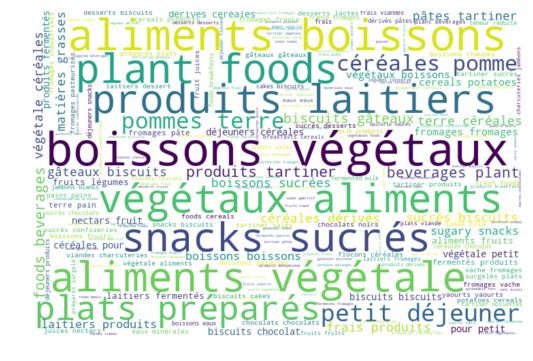

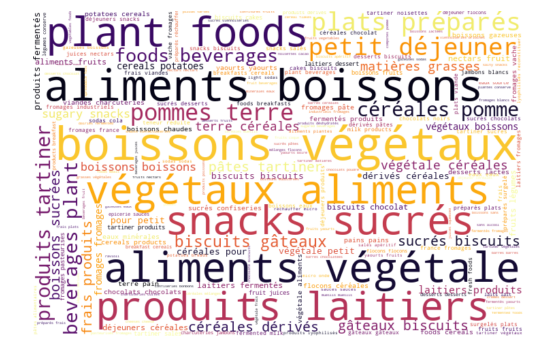

In [363]:
def getCategories(df, minlength=4, maxlength=20):
    cats = pd.DataFrame([x.lower() for cats in df["categories"] for x in re.split("\W", str(cats))], columns=["categories"])
    return cats[cats["categories"].apply(lambda x: (len(x) >= minlength) & (len(x) <= maxlength))]

def generateWordCloud(df, stopwordsAdd={}, **kwargs):
    stopwords = set(STOPWORDS)
    stopwords.update(stopwordsAdd)
    kwargsWC = {"background_color":"white", "stopwords":stopwords, "width":720, "height":480, "margin":0, "colormap":"inferno"}
    kwargsWC.update(kwargs)
    categories = getCategories(nonOrganicDf)
    categoriesText = " ".join(categories["categories"])
    
    wc = WordCloud(**kwargsWC).generate(categoriesText)

    # Display the generated image:
    plt.figure(figsize=figsize)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

stopwords = {"base", "based", "origine"}
generateWordCloud(organicDf, stopwords, colormap = "viridis")
generateWordCloud(nonOrganicDf, stopwords, colormap = "inferno")

In [198]:
def printColumns(table):
    for x in table.columns:
        print(x)


In [199]:
printColumns(organicDf)

_id
_keywords
additives_debug_tags
additives_n
additives_old_n
additives_old_tags
additives_original_tags
additives_prev_n
additives_prev_original_tags
additives_prev_tags
additives_tags
additives_tags_n
allergens
allergens_debug_tags
allergens_from_ingredients
allergens_from_user
allergens_hierarchy
allergens_tags
amino_acids_prev_tags
amino_acids_tags
brands
brands_debug_tags
brands_tags
categories
categories_debug_tags
categories_hierarchy
categories_prev_hierarchy
categories_prev_tags
categories_tags
checked
checkers
checkers_tags
cities_tags
code
codes_tags
complete
completed_t
correctors
correctors_tags
countries
countries_beforescanbot
countries_debug_tags
countries_hierarchy
countries_tags
created_t
creator
debug_param_sorted_langs
debug_tags
editors
editors_tags
emb_code
emb_codes
emb_codes_20141016
emb_codes_debug_tags
emb_codes_orig
emb_codes_tags
entry_dates_tags
expiration_date
expiration_date_debug_tags
fruits-vegetables-nuts_100g_estimate
generic_name
generic_name_ar
gen

In [212]:
def toFloat(x):
    try:
        return float(x)
    except:
        return np.nan

In [250]:
cats = ["pain", "bread", "mie"]
catOrganic = organicDf[organicDf["_keywords"].apply(lambda x: contains(cats, x))]
catNOrganic = nonOrganicDf[organicDf["_keywords"].apply(lambda x: contains(cats, x))]

count    2998.000000
mean     1159.357869
std       847.022283
min         0.000000
25%       322.000000
50%      1165.000000
75%      1781.000000
max      3766.000000
Name: nutriments, dtype: float64


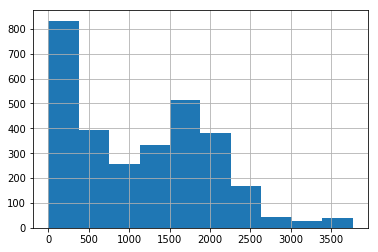

In [219]:
energy = organicDf["nutriments"].apply(lambda x: toFloat(x.setdefault("energy_100g", 0))).dropna()
energy = energy[energy < 4000]
print(energy.describe())
energy.hist()
plt.show()

In [317]:
def gatherNutriments(df, nutriment, p=5):
    vals = df["nutriments"].apply(lambda x: toFloat(x.setdefault("{}_100g".format(nutriment), 0))).dropna().values
    vMin = np.percentile(vals, p)
    vMax = np.percentile(vals, 100 - p)
    return vals[(vals >= vMin) & (vals <= vMax)]

energy                                  4.414944974651499e-07
energy-from-fat                         nan
fat                                     0.00011093181170371092
saturated-fat                           1.273923563358485e-05
butyric-acid                            nan
caproic-acid                            nan
caprylic-acid                           nan
capric-acid                             nan
lauric-acid                             nan
myristic-acid                           nan
palmitic-acid                           nan
stearic-acid                            nan
arachidic-acid                          nan
behenic-acid                            nan
lignoceric-acid                         nan
ceroticacid                             nan
montanic-acid                           nan
melissic-acid                           nan
monounsaturated-fat                     nan
polyunsaturated-fat                     nan
omega-3-fat                             nan
alpha-linolenic-acid 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)



arachidonic-acid                        nan
gamma-linoleni-acid                     nan
dihomo-gamma-linolenic-acid             nan
omega-9-fat                             nan
oleic-acid                              nan
elaidic-acid                            nan
gondoic-acid                            nan
mead-acid                               nan
erucic-acid                             nan
nervonic-acid                           nan
trans-fat                               nan
cholesterol                             nan
carbohydrates                           1.285701990122207e-07
sugars                                  5.0857747759682786e-26
sucrose                                 nan
glucose                                 nan
fructose                                nan
lactose                                 nan
maltose                                 nan
maltodextrins                           nan
starch                                  nan
polyols                               

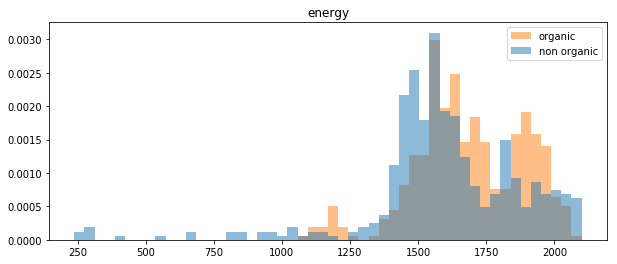

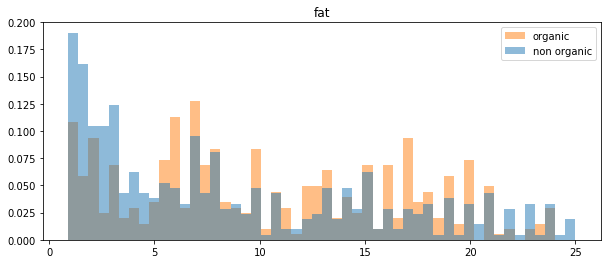

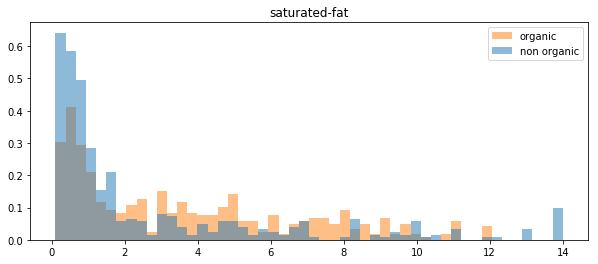

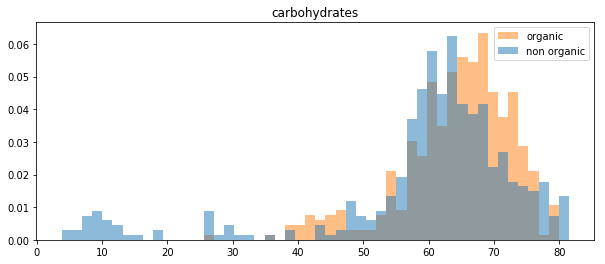

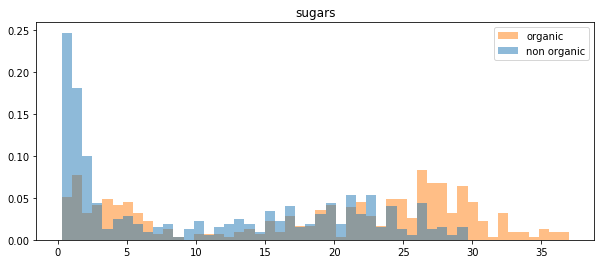

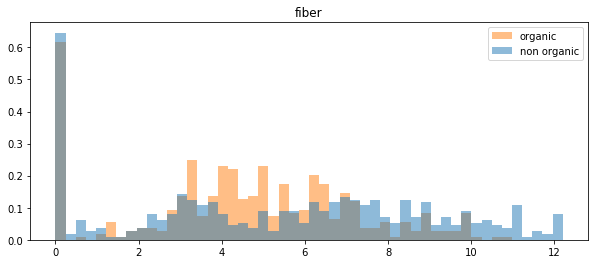

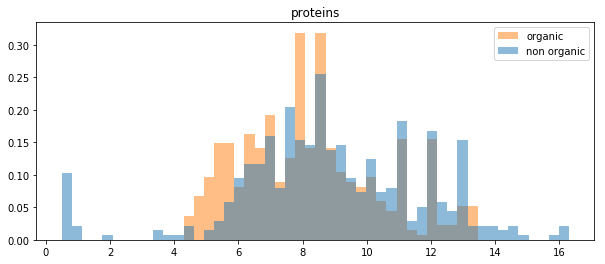

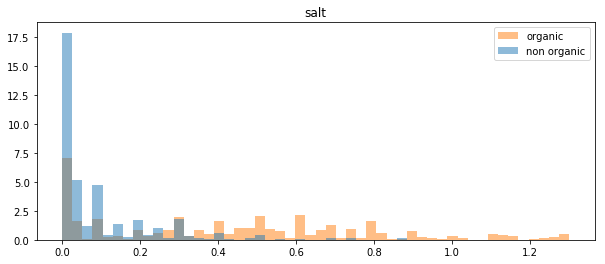

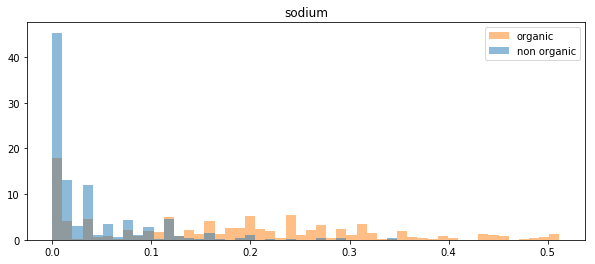

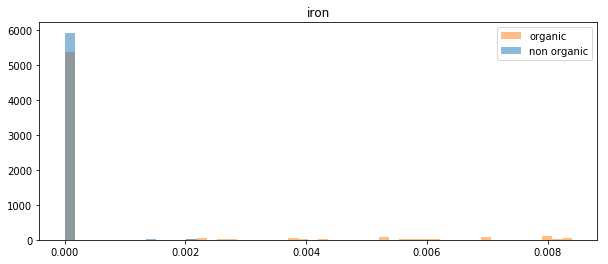

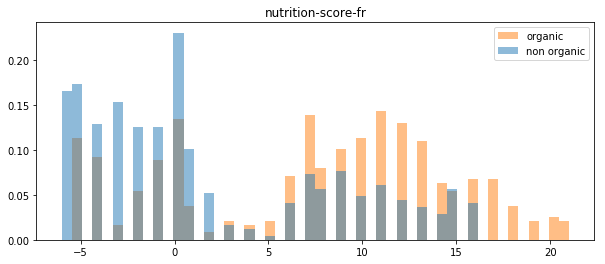

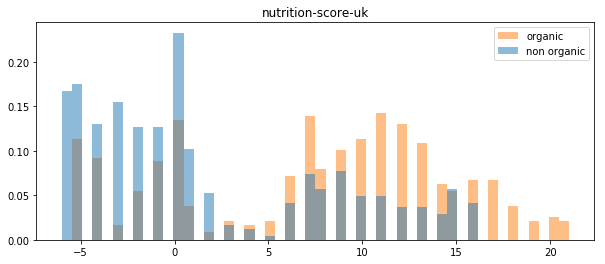

In [318]:
cats = ["céréales"]
catOrganic = organicDf[organicDf["categories"].apply(lambda x: contains(cats, str(x)))]
catNOrganic = nonOrganicDf[nonOrganicDf["categories"].apply(lambda x: contains(cats, str(x)))]
nutriments = ["energy","energy-from-fat","fat","saturated-fat","butyric-acid","caproic-acid","caprylic-acid","capric-acid","lauric-acid","myristic-acid","palmitic-acid","stearic-acid","arachidic-acid","behenic-acid","lignoceric-acid","ceroticacid","montanic-acid","melissic-acid","monounsaturated-fat","polyunsaturated-fat","omega-3-fat","alpha-linolenic-acid","eicosapentaenoic-acid","docosahexaenoic-acid","omega-6-fat","linoleic-acid","arachidonic-acid","gamma-linoleni-acid","dihomo-gamma-linolenic-acid","omega-9-fat","oleic-acid","elaidic-acid","gondoic-acid","mead-acid","erucic-acid","nervonic-acid","trans-fat","cholesterol","carbohydrates","sugars","sucrose","glucose","fructose","lactose","maltose","maltodextrins","starch","polyols","fiber","proteins","casein","serum-proteins","nucleotides","salt","sodium","alcohol","vitamin-a","beta-carotene","vitamin-d","vitamin-e","vitamin-k","vitamin-c","vitamin-b1","vitamin-b2","vitaminpp","vitamin-b6","vitamin-b9","vitamin-b12","biotin","pantothenic-acid","silica","bicarbonate","potassium","chloride","calcium","phosphorus","iron","magnesium","zinc","copper","manganese","fluoride","selenium","chromium","molybdenum","iodine","caffeine","taurine","ph","fruits-vegetables-nuts","collagen-meat-protein-ratio","cocoa","chlorophyl","carbon-footprint","nutrition-score-fr","nutrition-score-uk"]
# nutriments = ["energy","vitamin-a","beta-carotene","vitamin-d","vitamin-e","vitamin-k","vitamin-c","vitamin-b1","vitamin-b2","vitaminpp","vitamin-b6","vitamin-b9","vitamin-b12"]
for nutriment in nutriments:
    orgNut = gatherNutriments(catOrganic, nutriment)
    nOrgNut = gatherNutriments(catNOrganic, nutriment)
    print("{: <40}{}".format(nutriment, ttest_ind(orgNut, nOrgNut).pvalue))
    if (np.mean(orgNut) > 0) &  (np.mean(nOrgNut) > 0):
        plt.figure(figsize=(10, 4))
        plt.hist([orgNut, nOrgNut], density=True, bins=50, histtype ="stepfilled", alpha=0.5)
        plt.legend(["organic", "non organic"])
        plt.title(nutriment)
plt.show()

In [292]:
organicCategories = pd.DataFrame([x.lower() for cats in organicDf["categories"] for x in re.split("[ ,]", str(cats))], columns=["categories"])
organicCategories[organicCategories["categories"].apply(lambda x: len(x) > 2)].groupby("categories").agg({"categories": "count"}).sort_values("categories", ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: 'categories' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  from ipykernel import kernelapp as app


,categories
categories,
aliments,5965
boissons,4769
base,4130
produits,3444
fruits,3205
végétaux,3199
céréales,2961
végétale,2471
d'origine,2456


In [293]:
nonOrganicCategories = pd.DataFrame([x.lower() for cats in nonOrganicDf["categories"] for x in re.split("[ ,]", str(cats))], columns=["categories"])
nonOrganicCategories[nonOrganicCategories["categories"].apply(lambda x: len(x) > 2)].groupby("categories").agg({"categories": "count"}).sort_values("categories", ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: 'categories' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  from ipykernel import kernelapp as app


,categories
categories,
boissons,8901
aliments,8783
produits,7529
base,7472
plats,5231
fruits,4996
végétaux,4585
fromages,4516
préparés,4179


In [279]:
categories["categories"].apply(lambda x: len(x) > 2)

0         True
1        False
2         True
3        False
4         True
5        False
6         True
7         True
8         True
9         True
10        True
11        True
12       False
13        True
14       False
15        True
16        True
17       False
18        True
19        True
20        True
21        True
22        True
23        True
24       False
25        True
26        True
27       False
28        True
29       False
         ...  
31909     True
31910     True
31911    False
31912     True
31913    False
31914     True
31915    False
31916     True
31917    False
31918     True
31919     True
31920     True
31921     True
31922     True
31923     True
31924     True
31925     True
31926     True
31927     True
31928     True
31929     True
31930     True
31931     True
31932     True
31933     True
31934     True
31935     True
31936     True
31937    False
31938     True
Name: categories, Length: 31939, dtype: bool

In [168]:
def contains(strList, container):
    for s in strList:
        if s in container:
            return True
    return False

def showCols(table):
    for x in table.columns:
        print(x)

nonOrganicDf["category"] = nonOrganicDf["categories"].str.split(',', expand=True)[0]
nonOrganicDf[nonOrganicDf["_keywords"].apply(lambda x: contains(["pain", "bread", "mie"], x))][["generic_name", "brands"]]

,generic_name,brands


In [165]:
organicDf[organicDf["_keywords"].apply(lambda x: contains(["pain", "bread", "mie"], x))][["generic_name", "brands"]]

,generic_name,brands
17,"Pain complet à base de seigle, avoine et orge ...",Bjorg
35,Biscottes au sarrasin,Le pain des fleurs
44,Pain d'Épices au Miel Bio,Bjorg
59,Biscottes au germe de blé issues de l'agricult...,"Bio Village,Marque Repère"
70,Biscottes,"Bio Village,Marque Repère"
78,Pain d'épices Bio,Carrefour
81,Pain de mie bio complet,La Boulangère
86,Pain au lait issu de l'agriculture biologique,"Carrefour BIO,Carrefour"
88,Tartines Craquantes Sarrasin,Céréal Bio
89,Pain au lait issu de l'agriculture biologique,La Boulangère


In [158]:
showCols(nonOrganicDf)

_id
_keywords
additives_debug_tags
additives_n
additives_old_n
additives_old_tags
additives_original_tags
additives_prev_n
additives_prev_original_tags
additives_prev_tags
additives_tags
additives_tags_n
allergens
allergens_debug_tags
allergens_from_ingredients
allergens_from_user
allergens_hierarchy
allergens_tags
amino_acids_prev_tags
amino_acids_tags
brands
brands_debug_tags
brands_tags
categories
categories_debug_tags
categories_hierarchy
categories_prev_hierarchy
categories_prev_tags
categories_tags
checked
checkers
checkers_tags
cities_tags
code
codes_tags
complete
completed_t
correctors
correctors_tags
countries
countries_beforescanbot
countries_debug_tags
countries_hierarchy
countries_tags
created_t
creator
debug_param_sorted_langs
debug_tags
editors
editors_tags
emb_code
emb_codes
emb_codes_20141016
emb_codes_debug_tags
emb_codes_orig
emb_codes_tags
entry_dates_tags
expiration_date
expiration_date_debug_tags
fruits-vegetables-nuts_100g_estimate
generic_name
generic_name_ar
gen

In [14]:
countriesDf = getOFFDataFrame("countries")
countriesDf = countriesDf.sort_values("products", ascending=False)

244 entries gathered


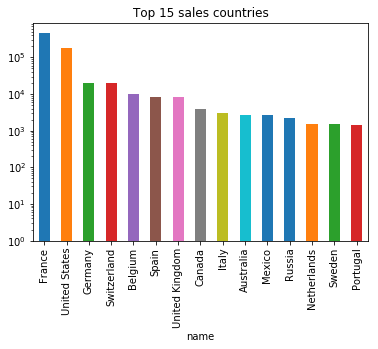

In [15]:
df = countriesDf.head(15)
df.plot.bar(x="name", y="products", legend=False, log=True)
plt.title("Top 15 sales countries")
plt.show()

In [57]:
ingredientsDf = getOFFDataFrame("nutrient-levels")
ingredientsDf = ingredientsDf.sort_values("products", ascending=False)
ingredientsDf

23 entries gathered


,id,name,products,url
0,en:sugars-in-low-quantity,Sugars in low quantity,76033,https://world.openfoodfacts.org/nutrient-level...
1,en:saturated-fat-in-low-quantity,Saturated fat in low quantity,70177,https://world.openfoodfacts.org/nutrient-level...
2,en:salt-in-low-quantity,Salt in low quantity,69260,https://world.openfoodfacts.org/nutrient-level...
3,en:fat-in-low-quantity,Fat in low quantity,58763,https://world.openfoodfacts.org/nutrient-level...
4,en:sugars-in-high-quantity,Sugars in high quantity,56442,https://world.openfoodfacts.org/nutrient-level...
5,en:salt-in-moderate-quantity,Salt in moderate quantity,54315,https://world.openfoodfacts.org/nutrient-level...
6,en:fat-in-moderate-quantity,Fat in moderate quantity,52229,https://world.openfoodfacts.org/nutrient-level...
7,en:saturated-fat-in-high-quantity,Saturated fat in high quantity,46716,https://world.openfoodfacts.org/nutrient-level...
8,en:fat-in-high-quantity,Fat in high quantity,40595,https://world.openfoodfacts.org/nutrient-level...
9,en:saturated-fat-in-moderate-quantity,Saturated fat in moderate quantity,31919,https://world.openfoodfacts.org/nutrient-level...


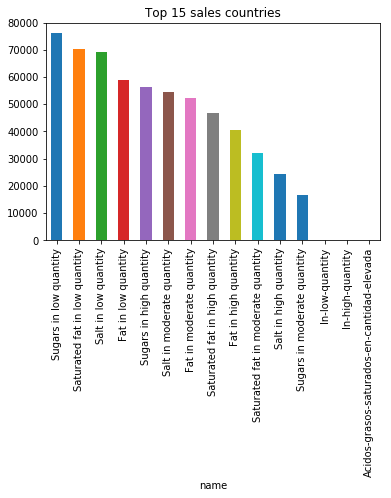

In [17]:
ingDf = ingredientsDf.head(15)
ingDf.plot.bar(x="name", y="products", legend=False)
plt.title("Top 15 sales countries")
plt.show()

In [18]:
result = json.load(urlopen(OFF_API_PATH.format("country/france/2")))
for k, v in result.items():
    try:
        print(k, len(v))
    except:
        print(k, v)

page 1
count 450875
skip 20
products 20
page_size 20


In [19]:
def findKey(data):
    for k, v in data.items():
        if isinstance(v, list):
            return k

def gatherOFFDataFramePages(adress, pages = None):
    result = json.load(urlopen(OFF_API_PATH.format(adress)))
    count = result["count"]
    key = findKey(result)
    df = pd.DataFrame(result[key])
    if "page" in result.keys():
        nbPages = (count - 1) // result["page_size"] + 1
        if pages != None:
            nbPages = np.min([nbPages, pages])
        for i in range(2, nbPages+1):
            currResult = json.load(urlopen(OFF_API_PATH.format(adress + "/" + str(i))))
            currDf = pd.DataFrame(currResult[key])
            df = df.append(currDf, sort=False)
            print(i, df["_id"].count())
    return df

In [20]:
franceDf = gatherOFFDataFramePages("country/france", 5)
franceDf[["_id", "product_name", "labels", "ingredients_text", "last_modified_t", "brands"]].head(100)

2 40
3 60
4 80
5 100


,_id,product_name,labels,ingredients_text,last_modified_t,brands
0,3270720300354,Cacahuètes caramélisées,,,1542972995,Daco Bell
1,3272320013405,Milleret Ser Francuski Roucoulons,NaN,NaN,1542972979,NaN
2,3588400258384,Citronnettes,NaN,NaN,1542972967,NaN
3,3700353615124,Patate douce biologique,NaN,NaN,1542972908,NaN
4,2000000083848,NaN,NaN,NaN,1542972892,NaN
5,8410261777160,Zumo 100% Exprimido Veggies,NaN,NaN,1542972890,NaN
6,8410261604619,Zumo de manzana,,Zumo de manzana concentrado y acidulante: ácid...,1542972865,Don Simón
7,7613036242172,rick&mix,NaN,NaN,1542972852,NaN
8,3701138105380,"Salade de poulet, boulgour, patate douce",NaN,NaN,1542972818,NaN
9,3251320020422,Les Gros Bio 4 Oeufs Bio Fermiers,"Sans OGM,AB Agriculture Biologique,Bio europée...",4 _œufs_ bio fermiers,1542972764,Loué


In [21]:
for x in franceDf.columns:
    print(x)

_id
_keywords
additives_debug_tags
additives_n
additives_old_n
additives_old_tags
additives_original_tags
additives_prev_n
additives_prev_original_tags
additives_prev_tags
additives_tags
allergens
allergens_debug_tags
allergens_from_ingredients
allergens_from_user
allergens_hierarchy
allergens_tags
amino_acids_prev_tags
amino_acids_tags
brands
brands_debug_tags
brands_tags
categories
categories_debug_tags
categories_hierarchy
categories_prev_hierarchy
categories_prev_tags
categories_tags
checkers
checkers_tags
cities_tags
code
codes_tags
complete
completed_t
correctors
correctors_tags
countries
countries_beforescanbot
countries_debug_tags
countries_hierarchy
countries_tags
created_t
creator
debug_param_sorted_langs
debug_tags
editors
editors_tags
emb_codes
emb_codes_20141016
emb_codes_debug_tags
emb_codes_orig
emb_codes_tags
empty
entry_dates_tags
expiration_date
expiration_date_debug_tags
fruits-vegetables-nuts_100g_estimate
generic_name
generic_name_de
generic_name_de_debug_tags
gene

In [22]:
spark = SparkSession.builder.getOrCreate()
sqlContext = sqlContext = SQLContext(spark)

In [23]:
DATA_DIR = "../data/"
if os.path.exists(DATA_DIR+"openfoodfacts.parquet"):
    productsDf = spark.read.parquet(DATA_DIR + "openfoodfacts.parquet")
    #productsDf.show(2)
else:
    productsDf = spark.read.csv(DATA_DIR+'en.openfoodfacts.org.products.csv', header=True, sep="	") #load the dataset into a Spark dataframe
    #productsDf.show(2) #show the content (20 first rows)
    productsDf.write.parquet(DATA_DIR+"openfoodfacts.parquet", mode="overwrite") #save it in the Parquet format

for (k, v) in productsDf.dtypes:
    print("{: <20}:{}".format(k, v))

code                :string
url                 :string
creator             :string
created_t           :string
created_datetime    :string
last_modified_t     :string
last_modified_datetime:string
product_name        :string
generic_name        :string
quantity            :string
packaging           :string
packaging_tags      :string
brands              :string
brands_tags         :string
categories          :string
categories_tags     :string
categories_en       :string
origins             :string
origins_tags        :string
manufacturing_places:string
manufacturing_places_tags:string
labels              :string
labels_tags         :string
labels_en           :string
emb_codes           :string
emb_codes_tags      :string
first_packaging_code_geo:string
cities              :string
cities_tags         :string
purchase_places     :string
stores              :string
countries           :string
countries_tags      :string
countries_en        :string
ingredients_text    :string
allergens

In [24]:
dfConsoAll = dfConso.merge(dfIndiv, left_on="nomen", right_on="nomen", how="inner")

In [25]:
def plotBar(table, idx, col, x):
    consos = table[[col, idx, x]].groupby([idx, col]).count().unstack(level=1)[x]
    consos = consos.swapaxes(0,1)
    consos = consos / consos.sum(axis=0)
    consos = consos.swapaxes(0,1)
    consos.index = mapCorrespondances(consos.index, idx)
    consos.columns = mapCorrespondances(consos.columns, col)
    consos.plot.bar(stacked=True)
    plt.show()

def plotScatter(table, col1, col2):
    data = table[[col1, col2]].values
    plt.scatter(data[:,0], data[:,1])
    plt.show()
    
def getBinsFunc(x, nbins):
    xmin = np.min(x)
    xmax = np.max(x) * 1.01
    return lambda v: np.int16(nbins * (v - xmin) / (xmax - xmin)) * (xmax - xmin) + xmin
    
def plotScatterCateX(table, x, y, index, bins):
    consos = table[[x, y, index]]
    f = getBinsFunc(consos[y], bins)
    consos[y] = f(consos[y])
    plotBar(consos, x, y, index)
    

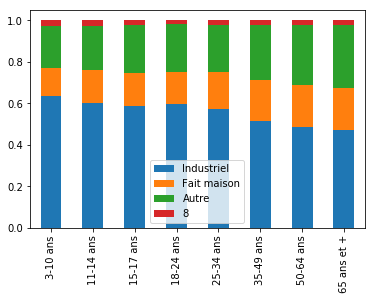

In [26]:
plotBar(dfConsoAll, "tage", "typal3", "numlig")

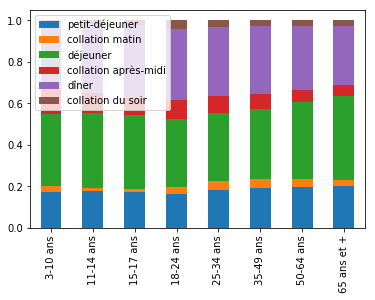

In [27]:
plotBar(dfConsoAll, "tage", "tyrep", "numlig")

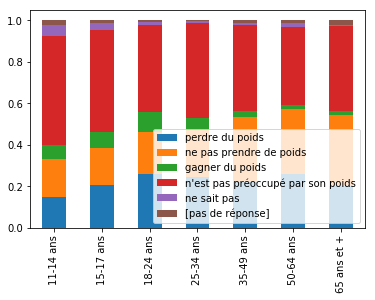

In [28]:
plotBar(dfIndiv, "tage", "essaipds", "nomen")

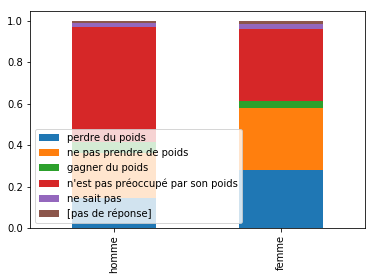

In [29]:
plotBar(dfIndiv, "sexe_ps", "essaipds", "nomen")

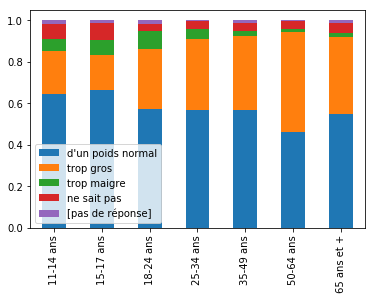

In [30]:
plotBar(dfIndiv, "tage", "opipoids", "nomen")

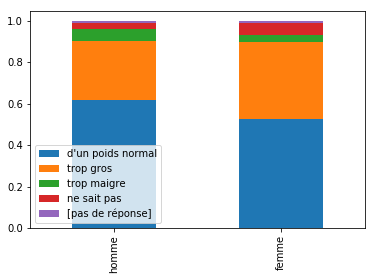

In [31]:
plotBar(dfIndiv, "sexe_ps", "opipoids", "nomen")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


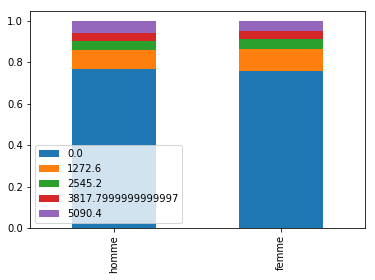

In [32]:
plotScatterCateX(dfIndiv, "sexe_ps", "modere_hebdo", "nomen", 5)

# Inference

In [33]:
from sklearn.decomposition import PCA

In [34]:
def plotPCAComponents(table, features, trainIndex = None, nbComps=4):
    # Train PCA
    data = table[features].values
    
    if trainIndex is None:
        trainIndex = np.ones(len(data), "bool")

    trainData = data[trainIndex]

    mu = np.mean(trainData, axis=0)
    sigma = np.std(trainData, axis=0)

    trainData = (trainData - mu) / sigma

    pca = PCA()
    pca.fit(trainData)
    
    #Show PCA first comps
    featuresNames = mapDescription(features)
    
    cumComponents = np.zeros(len(features))
    fig, ax = plt.subplots(figsize=figsize)
    for i in range(nbComps):
        components = np.abs(pca.components_[i, :])
        ax.bar(featuresNames, components, bottom=cumComponents)
        cumComponents += components
    plt.xticks(fontsize=12, rotation=90)
    plt.show()

In [35]:
def plotMeanValues(table, features, className, mincount=50):
    featuresNames = mapDescription(features)

    means = table.groupby(className).filter(lambda x: len(x) > mincount).groupby(className).mean()[features]
    means.columns = featuresNames
    means /= means.sum(axis=0)
    means = means.swapaxes(0, 1)
    means.columns = mapCorrespondances(means.columns, className)
    means.plot.bar(stacked=True, figsize=figsize)
    plt.show()

In [36]:
table = dfIndnut.merge(dfIndiv, left_on="nomen", right_on="nomen", how="inner")
className = "tage"
samples = "nomen"
cateFeatures = []
numFeatures = np.array(["nutj{}".format(i) for i in range(4, 29)] + ["nutj{}".format(i) for i in range(30, 40)])
featuresNames = mapDescription(numFeatures)

data = table[numFeatures].values
labels = table[className].values

trainIndex = np.ones(len(data), "bool")
trainIndex[np.arange(int(len(data) * 0.8))] = False

trainData = data[trainIndex]
testData = data[~trainIndex]
trainLabels = labels[trainIndex]
testLabels = labels[~trainIndex]

mu = np.mean(trainData, axis=0)
sigma = np.std(trainData, axis=0)

trainData = (trainData - mu) / sigma
testData = (testData - mu) / sigma


pca = PCA()
pca.fit(trainData)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

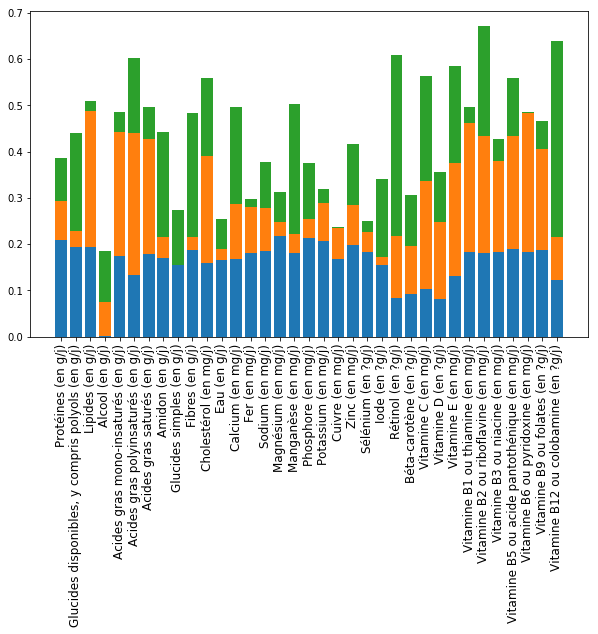

In [37]:
nbComps = 3
cumComponents = np.zeros(len(numFeatures))
fig, ax = plt.subplots(figsize=figsize)
for i in range(nbComps):
    components = np.abs(pca.components_[i, :])
    ax.bar(featuresNames, components, bottom=cumComponents)
    cumComponents += components
plt.xticks(fontsize=12, rotation=90)
plt.show()

In [38]:
indnutIndTable = dfIndnut.merge(dfIndiv, left_on="nomen", right_on="nomen", how="inner")
columns = {col:col[:-2] for col in indnutIndTable.columns if col[-2:] == "_x"}
dropColumns = [col for col in indnutIndTable.columns if col[-2:] == "_y"]
indnutIndTable = indnutIndTable.rename(columns = columns).drop(columns= dropColumns)

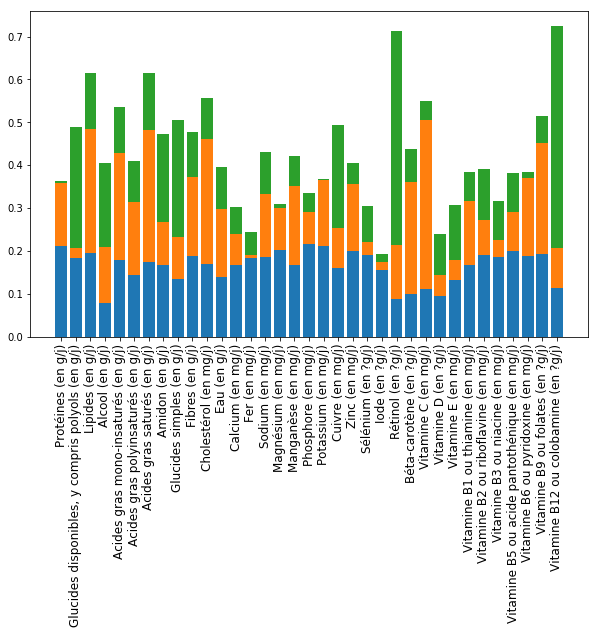

In [39]:
plotPCAComponents(indnutIndTable, numFeatures, nbComps=3)

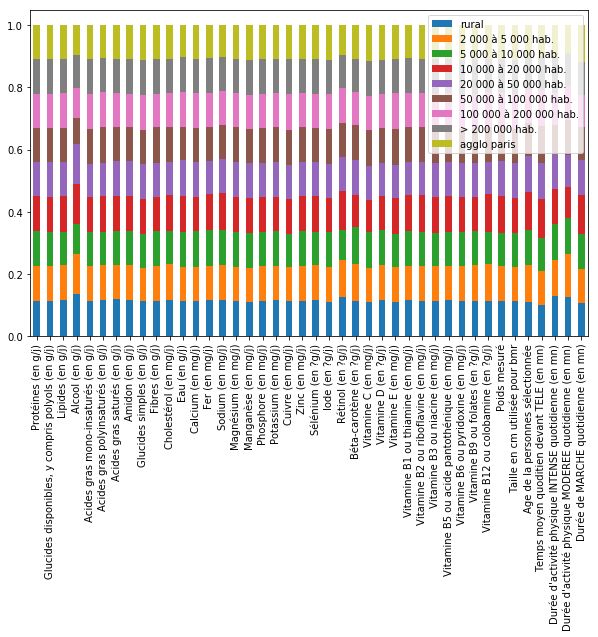

In [40]:
className = "agglo9"
samples = "nomen"
cateFeatures = []
numFeatures = ["nutj{}".format(i) for i in range(4, 29)] + ["nutj{}".format(i) for i in range(30, 40)] + ["poidsm", "taille", "v2_age", "tele", "intense_j", "modere_j", "marche_j"]
featuresNames = mapDescription(numFeatures)

table = indnutIndTable
means = table.groupby(className).mean()[numFeatures]
means.columns = featuresNames
means /= means.sum(axis=0)
means = means.swapaxes(0, 1)
means.columns = mapCorrespondances(means.columns, className)
means.plot.bar(stacked=True, figsize=figsize)
plt.show()

In [182]:
x = "tage"
df = dfIndiv.groupby(x).agg({"nomen": "count"})
df.index = mapCorrespondances(np.int8(df.index), x)
df

,nomen
3-10 ans,574
11-14 ans,456
15-17 ans,425
18-24 ans,257
25-34 ans,432
35-49 ans,837
50-64 ans,750
65 ans et +,348


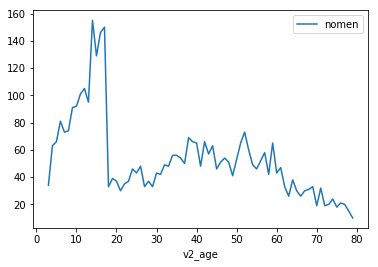

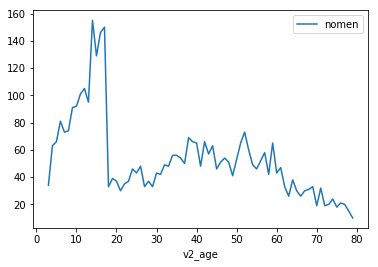

In [189]:
df = dfIndiv.groupby("v2_age").agg({"v2_age":"max", "nomen": "count"}).rename(columns={"nomen": "count"})
df.plot("v2_age", "nomen")
plt.xlabel("age")
plt.ylabel("count")
plt.show()

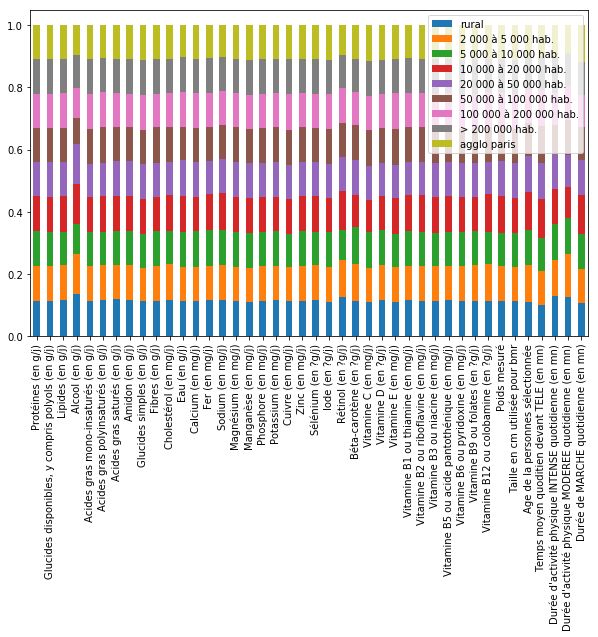

In [41]:
plotMeanValues(indnutIndTable, numFeatures, "agglo9")

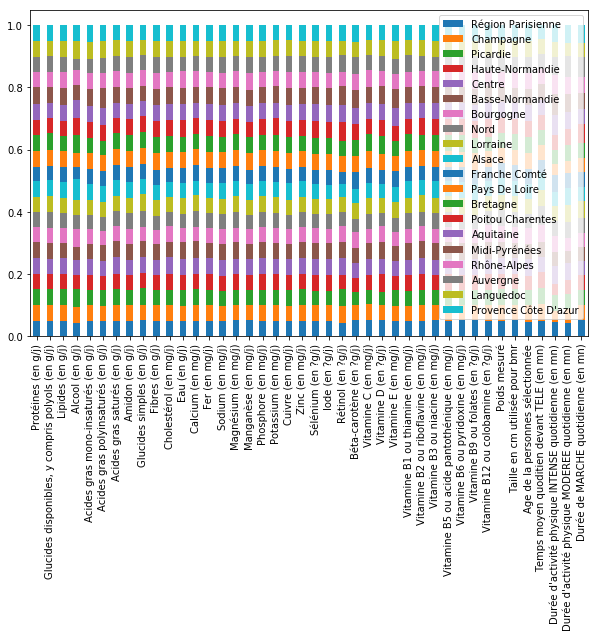

In [222]:
plotMeanValues(indnutIndTable, numFeatures, "region")

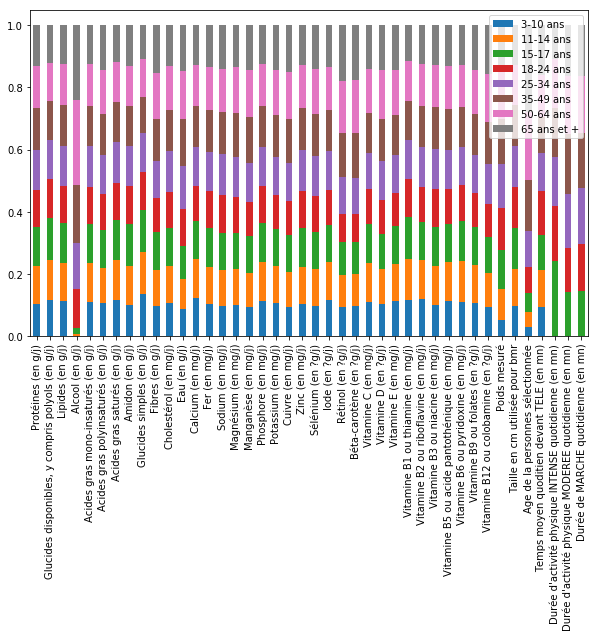

In [42]:
plotMeanValues(indnutIndTable, numFeatures, "tage")

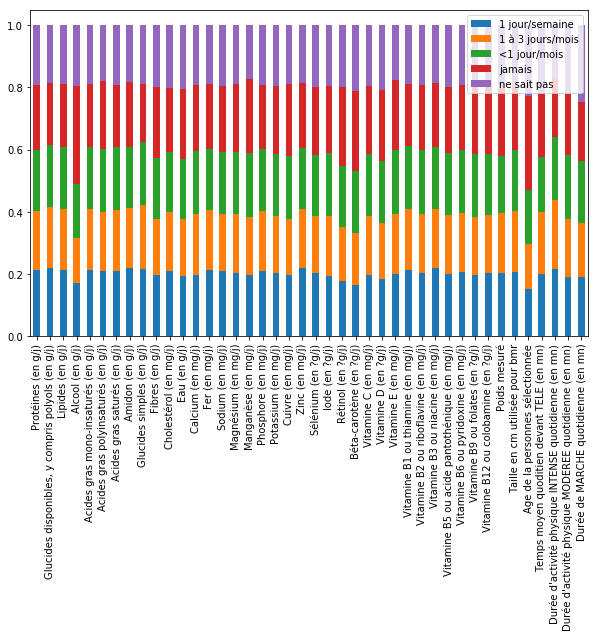

In [43]:
plotMeanValues(indnutIndTable, numFeatures, "fastfood")

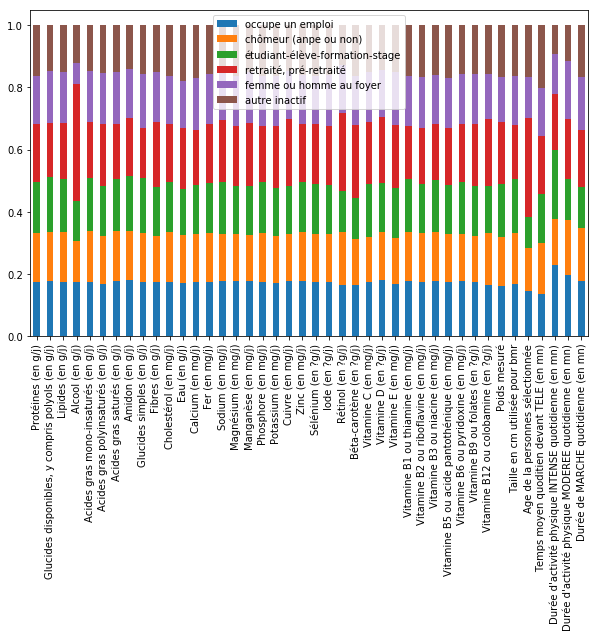

In [44]:
plotMeanValues(indnutIndTable, numFeatures, "situ_prof")

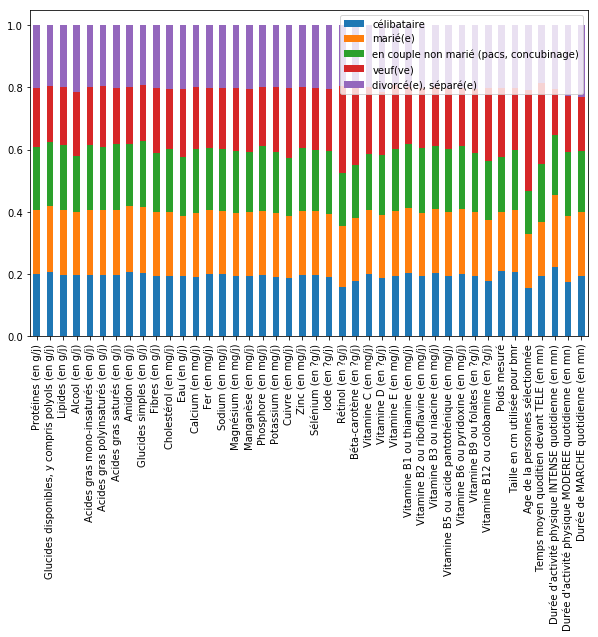

In [45]:
plotMeanValues(indnutIndTable, numFeatures, "situ_mat")

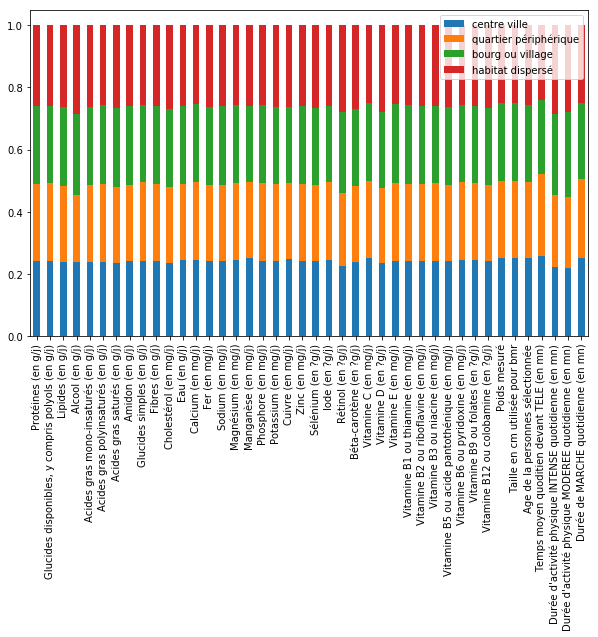

In [46]:
plotMeanValues(indnutIndTable, numFeatures, "loc_log")

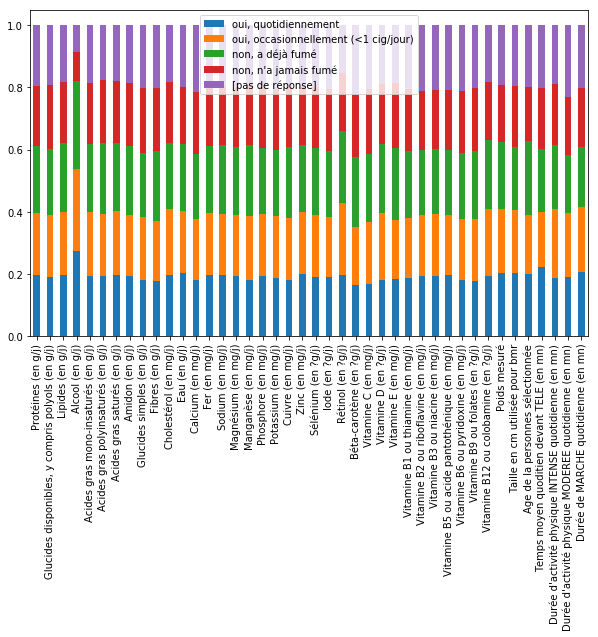

In [47]:
plotMeanValues(indnutIndTable, numFeatures, "fume")

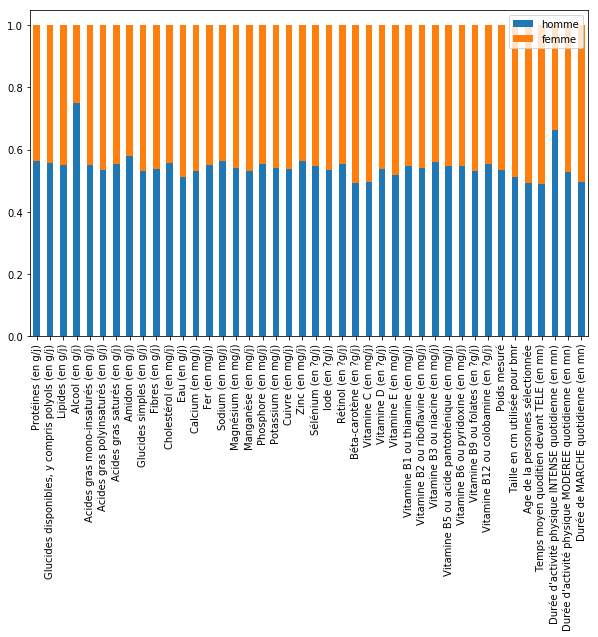

In [48]:
plotMeanValues(indnutIndTable, numFeatures, "sexe_ps")

In [49]:
for col in indnutIndTable.columns:
    print(col)

nomen
sexe_ps
ech
v2_age
aet
nutj4
nutj5
nutj6
nutj7
nutj8
nutj9
nutj10
nutj11
nutj12
nutj13
nutj14
nutj15
nutj16
nutj17
nutj18
nutj19
nutj20
nutj21
nutj22
nutj23
nutj24
nutj25
nutj26
nutj27
nutj28
nutj30
nutj31
nutj32
nutj33
nutj34
nutj35
nutj36
nutj37
nutj38
nutj39
sexeps
fqcantine
entrerep
colmata
distrib
distconf
distfruit
distsoli
fastfood
ffrepas
selassent
selassleg
selassfec
selassvp
selassvps
selassoeuf
enrich
lardcru
sauccru
boeufcru
chevcru
porccru
volcru
poiscru
oeufcru
shboeufcuis
boeufcuis
rotboeufcuis
foiecuis
veaucuis
porccuis
sauccuis
chevcuis
agncuis
cotagncuis
volcuis
intalim
intalinouv
infopub
infoprof
infointern
etiquetad
etiqingr
etiqnut
etiqport
etiqclnut
etiqclsant
bonalim
regimedj
poids12
poids12nsp
essaipds
contalim
contap
opipoids
voeupoids
nbgeneral
nbspecial
pdsmax
agepmax
agepmaxnsp
pdsmin
pdsminnsp
agepmin
agepminnsp
cyclepds
enceinte
allaite
enceinte12
menopaus
ths
fume
nbcigrjm
nbpipejm
nbcigrsm
nbpipesm
agefumem
nbcigrja
nbpipeja
nbcigrsa
nbpipesa
nbcig

In [55]:
dfNomenclature.groupby("libgr").count()

,codgr,sougr,libsougr,codal,libal
libgr,,,,,
-,1,1,1,1,1
abats,17,17,17,17,17
aliments destinés à une alimentation particulière,16,16,16,16,16
autres boissons chaudes,11,11,11,11,11
autres céréales,4,4,4,4,4
autres graisses,6,6,6,6,6
beurre,15,15,15,15,15
biscuits sucrés ou salés et barres,34,34,34,34,34
boissons alcoolisées,38,38,38,38,38


In [52]:
dfNomenclature

,codgr,libgr,sougr,libsougr,codal,libal
0,1,pain et panification sèche,1,pain,7001,pain baguette
1,1,pain et panification sèche,1,pain,7004,pain grillé maison
2,1,pain et panification sèche,1,pain,7012,pain courant français boule à la levure
3,1,pain et panification sèche,1,pain,7100,pain de campagne ou bis
4,1,pain et panification sèche,1,pain,7110,pain complet ou intégral artisanal
5,1,pain et panification sèche,1,pain,7125,pain de seigle et froment
6,1,pain et panification sèche,1,pain,7126,pain de seigle aux raisins
7,1,pain et panification sèche,1,pain,7160,pain baguette sans sel
8,1,pain et panification sèche,1,pain,7200,pain de mie
9,1,pain et panification sèche,1,pain,7225,pain brioché ou viennois


In [56]:
dfConso

,libmarq,typal3,nom_commercial,nomen,numlig,nojour,tyrep,noligne,codgr,sougr,codal,algra,alsuc,enric,diete,rien,typal2,qte_brute,qte_nette
0,summa aldi,2,x,110006,1.0,6,1,1.0,34,99,18151,0.0,0.0,0.0,0.0,1.0,4.0,250.0,250.0
1,tutti free,1,x,110006,2.0,6,1,2.0,30,1,31076,0.0,1.0,0.0,0.0,0.0,4.0,2.5,2.5
2,x,3,x,110006,3.0,6,1,3.0,1,1,7001,0.0,0.0,0.0,0.0,1.0,1.0,30.0,30.0
3,marque repère nadya,1,margarine allégée de tournesol 55%mg,110006,4.0,6,1,4.0,15,99,16632,1.0,0.0,0.0,0.0,0.0,1.0,5.0,5.0
4,albacore,1,x,110006,5.0,6,3,1.0,21,1,26039,0.0,0.0,0.0,0.0,1.0,2.0,30.0,30.0
5,x,2,x,110006,6.0,6,3,2.0,43,1,11110,0.0,0.0,0.0,0.0,1.0,1.0,6.0,6.0
6,x,3,x,110006,7.0,6,3,3.0,1,1,7001,0.0,0.0,0.0,0.0,1.0,1.0,30.0,30.0
7,danone,1,x,110006,8.0,6,3,4.0,10,3,19510,1.0,0.0,0.0,0.0,0.0,1.0,100.0,100.0
8,tutti free,1,x,110006,9.0,6,3,5.0,30,1,31076,0.0,1.0,0.0,0.0,0.0,4.0,2.5,2.5
9,cristaline,1,x,110006,10.0,6,3,6.0,31,4,18008,0.0,0.0,0.0,0.0,1.0,4.0,240.0,240.0
